In this post, we'll have a look at stereograms, in particular [autostereograms](https://en.wikipedia.org/wiki/Autostereogram). 

This post will introduce two methods of creating illusions of depth. The first one consists of using a pattern and shifting it repeatedly along the horizontal axis. The second one uses a depth map and a pattern and shifts the individual pixels of the pattern according to a depth map. In this case, the pattern used is often a random pattern, hence the term "random dot stereogram".

In the first part of this blog post, we will use horizontally repeated patterns to create an illusion of depth. In the second part of this post, we will turn to the depth map type stereogram. 

# Horizontally shifted patterns 

## First, some tools 

Before getting started, we will build some tools to work with images:

- a function that returns a new image in a given size, with a given background
- a function that displays an image

Let's get started with a blank image builder. We will use the scikit-image style and thus model images with numpy arrays. Let's import the packages we will need along the way:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage, skimage.io
%matplotlib inline

In [2]:
plt.rcParams['figure.dpi'] = 150

In [3]:
def blank_image(shape=(600, 800, 4),
               rgba=(255, 255, 255, 0)):
    "Returns a blank image, of size defined by shape and background color rgb."
    return np.ones(shape, dtype=np.float) * np.array(rgba) / 255.

In [4]:
img = blank_image()

Now that we have an image, let's write a function that displays it.

In [5]:
def display(img, colorbar=False):
    "Displays an image."
    plt.figure(figsize=(10, 10))
    if len(img.shape) == 2:
        i = skimage.io.imshow(img, cmap='gray')
    else:
        i = skimage.io.imshow(img)
    if colorbar:
        plt.colorbar(i, shrink=0.5, label='depth')
    plt.tight_layout()

/Users/kappamaki/anaconda/lib/python3.4/site-packages/skimage/io/_plugins/matplotlib_plugin.py:74: UserWarning: Low image dynamic range; displaying image with stretched contrast.
  warn("Low image dynamic range; displaying image with "


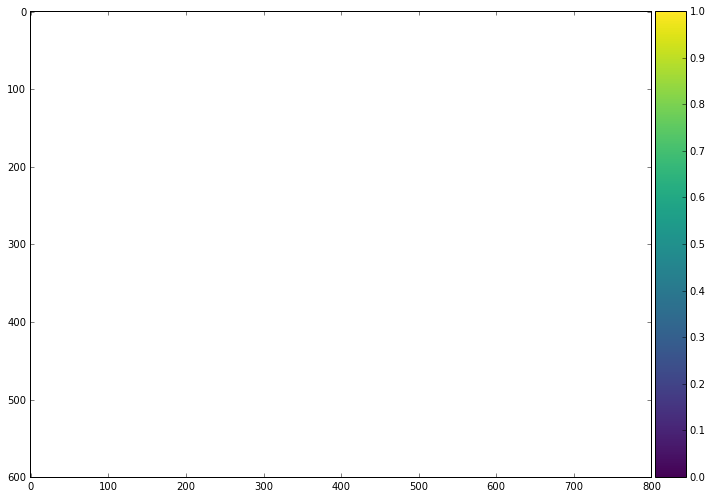

In [6]:
display(img)

## Tiling 

Now, let's address the tiling of patterns. First, we load the pattern that we will work with througout this post: a coin.

In [7]:
coin = skimage.io.imread('files/coin-icon.png')

What does this coin look like?

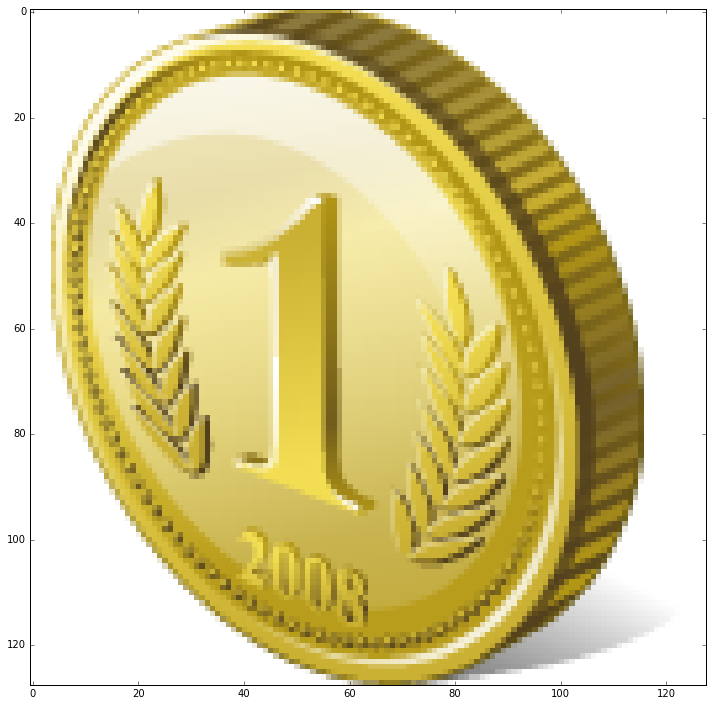

In [8]:
display(coin)

Let's now write a function that inserts a pattern onto an existing image.

In [9]:
def insert_pattern(background_img, pattern, location):
    """Inserts a pattern onto a background, at given location. Returns new image."""
    img = background_img.copy()
    r0, c0 = location
    r1, c1 = r0 + pattern.shape[0], c0 + pattern.shape[1]
    if r1 < background_img.shape[0] and c1 < background_img.shape[1]:
        img[r0:r1, c0:c1, :] = skimage.img_as_float(pattern)
    return img

Let's test this:

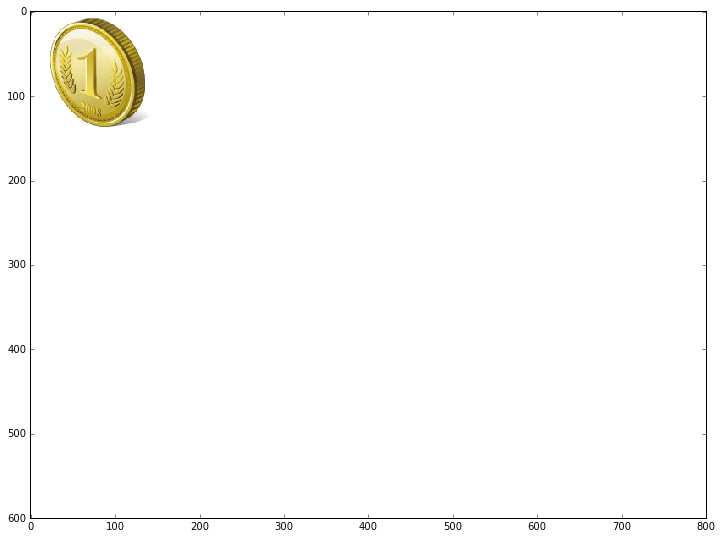

In [10]:
test_img = insert_pattern(img, coin, (10, 20))
display(test_img)

From there, we can write a horizontal tile function that maps a pattern a repeated number of times on an image.

In [11]:
def tile_horizontally(background_img, pattern, start_location, repetitions, shift):
    "Tiles a pattern on a background image, repeatedly with a given shift."
    img = background_img.copy()
    for i in range(repetitions):
        r, c = start_location
        c += i * shift
        img = insert_pattern(img, pattern, location=(r, c))
    return img

Let's test this:

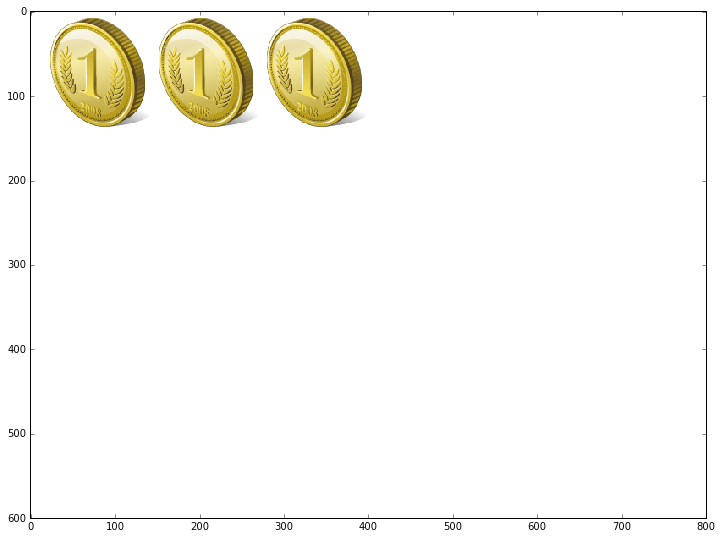

In [12]:
test_img = tile_horizontally(img, coin, (10, 20), 3, 128)
display(test_img)

Now that we have the basics going, let's imitate the examples found on the wikipedia page for autostereograms: three rows of coins, each with its own shift.

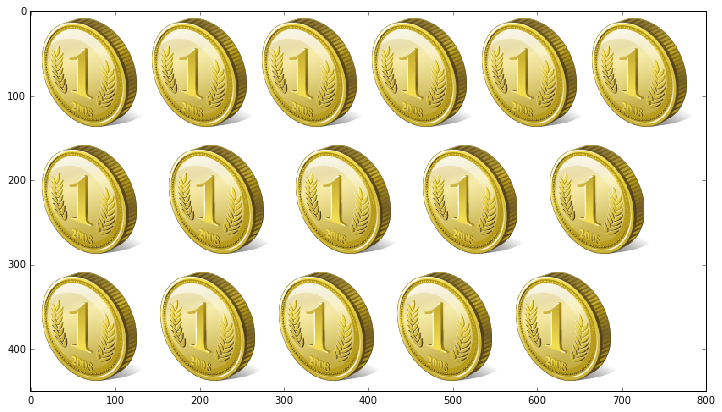

In [13]:
img = blank_image(shape=(450, 800, 4))
img = tile_horizontally(img, coin, (10, 10), 6, shift=130)
img = tile_horizontally(img, coin, (10 + 150, 10), 5, shift=150)
img = tile_horizontally(img, coin, (10 + 2*150, 10), 5, shift=140)
display(img)

If you look at this image with the so called wall-eyed look, I expect you to see the middle row to be pushed back inside the picture while the top and bottom row stand out. **Can you see it?** 

The conclusion from this experiment is that we can say that closely packed objects look more close to us than wider spaced ones.

Now, the question is: does it work vertically as well? We can actually answer that question: try to visualize the 3d pattern and then rotate your screen. To me, the illusion of depth goes away quite quickly, a slight tilt is sufficient to break the impression of depth.

This result is already interesting. But what about depth map based stereograms?

# Depth map based stereograms 

The wikipedia article on autostereograms describes the algorithm for creating depth map based stereograms like this:
>A computer program can take a depth map and an accompanying pattern image to produce an autostereogram. The program tiles the pattern image horizontally to cover an area whose size is identical to the depth map. Conceptually, at every pixel in the output image, the program looks up the grayscale value of the equivalent pixel in the depth map image, and uses this value to determine the amount of horizontal shift required for the pixel.
>
> One way to accomplish this is to make the program scan every line in the output image pixel-by-pixel from left to right. It seeds the first series of pixels in a row from the pattern image. Then it consults the depth map to retrieve appropriate shift values for subsequent pixels. For every pixel, it subtracts the shift from the width of the pattern image to arrive at a repeat interval. It uses this repeat interval to look up the color of the counterpart pixel to the left and uses its color as the new pixel's own color.

This is, to say the least, not a very clear explanation. Let's try to deconstruct this. We need two things:

- a pattern 
- a depth-map

First, let's create a pattern. We will use a random pattern made of gray values.

In [14]:
def make_pattern(shape=(16, 16), levels=64):
    "Creates a pattern from gray values."
    return np.random.randint(0, levels - 1, shape) / levels

Let's test this:

In [15]:
pattern = make_pattern(shape=(128, 64))

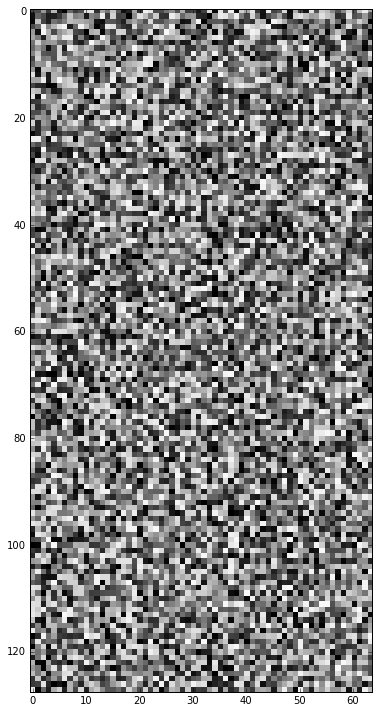

In [16]:
display(pattern)

Now, we would like to have a depth map. Let's create a depth map using a simple circle.

In [17]:
def create_circular_depthmap(shape=(600, 800), center=None, radius=100):
    "Creates a circular depthmap, centered on the image."
    depthmap = np.zeros(shape, dtype=np.float)
    r = np.arange(depthmap.shape[0])
    c = np.arange(depthmap.shape[1])
    R, C = np.meshgrid(r, c, indexing='ij')
    if center is None:
        center = np.array([r.max() / 2, c.max() / 2])
    d = np.sqrt((R - center[0])**2 + (C - center[1])**2)
    depthmap += (d < radius)
    return depthmap    

In [18]:
depthmap = create_circular_depthmap(radius=150)

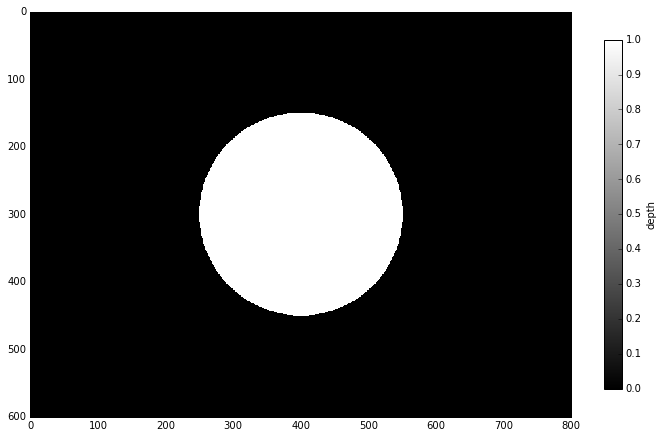

In [19]:
display(depthmap, colorbar=True)

Now that we're here, we will also create a function that normalizes a depthmap into the [0, 1] range:

In [20]:
def normalize(depthmap):
    "Normalizes values of depthmap to [0, 1] range."
    if depthmap.max() > depthmap.min():
        return (depthmap - depthmap.min()) / (depthmap.max() - depthmap.min())
    else:
        return depthmap

Finally, let's apply the algorithm.

In [21]:
def make_autostereogram(depthmap, pattern, shift_amplitude=0.1, invert=False):
    "Creates an autostereogram from depthmap and pattern."
    depthmap = normalize(depthmap)
    if invert:
        depthmap = 1 - depthmap
    autostereogram = np.zeros_like(depthmap, dtype=pattern.dtype)
    for r in np.arange(autostereogram.shape[0]):
        for c in np.arange(autostereogram.shape[1]):
            if c < pattern.shape[1]:
                autostereogram[r, c] = pattern[r % pattern.shape[0], c]
            else:
                shift = int(depthmap[r, c] * shift_amplitude * pattern.shape[1])
                autostereogram[r, c] = autostereogram[r, c - pattern.shape[1] + shift]
    return autostereogram

Let's test this!

In [22]:
autostereogram = make_autostereogram(depthmap, pattern)

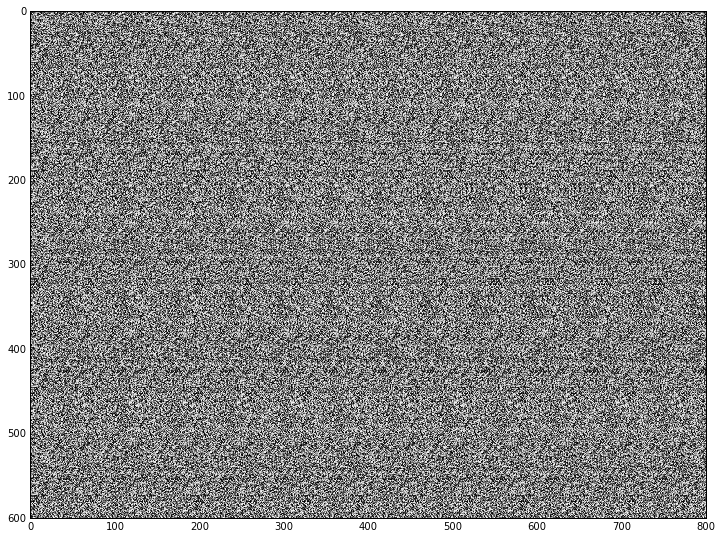

In [23]:
display(autostereogram)

What about an inverted one?

In [24]:
autostereogram = make_autostereogram(depthmap, pattern, invert=True)

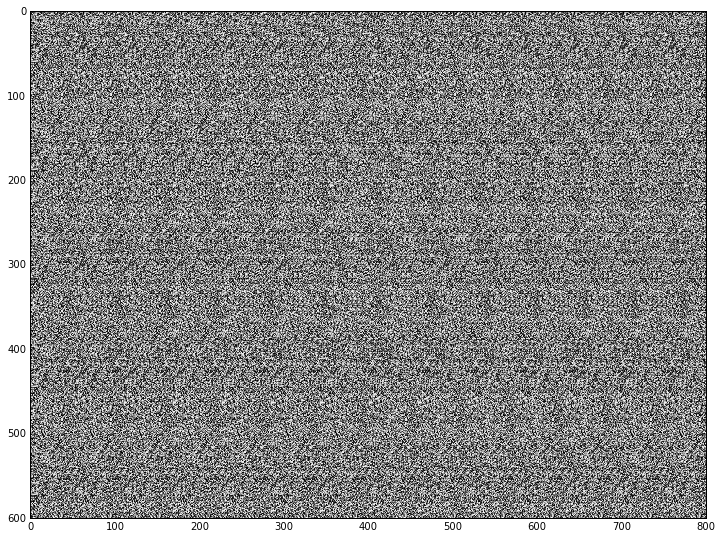

In [25]:
display(autostereogram)

This also works! Let's have a look at more elaborate patterns. For instance, we can combine different depthmaps.

In [26]:
depthmap = create_circular_depthmap(center=(200, 300), radius=100) + \
           create_circular_depthmap(center=(450, 500), radius=100) + \
           create_circular_depthmap(center=(200, 550), radius=150)
depthmap = normalize(depthmap)

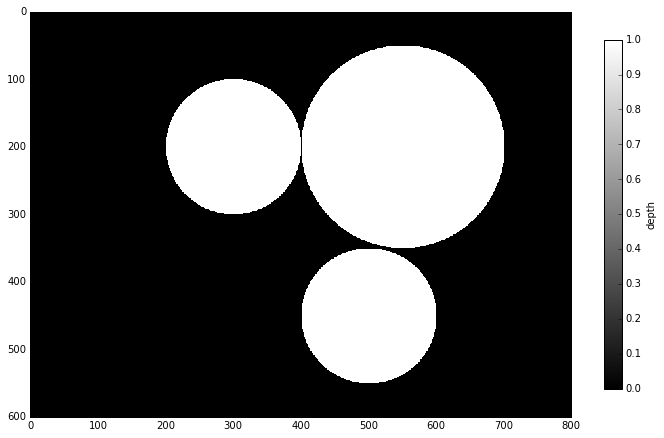

In [27]:
display(depthmap, colorbar=True)

In [28]:
autostereogram = make_autostereogram(depthmap, pattern)

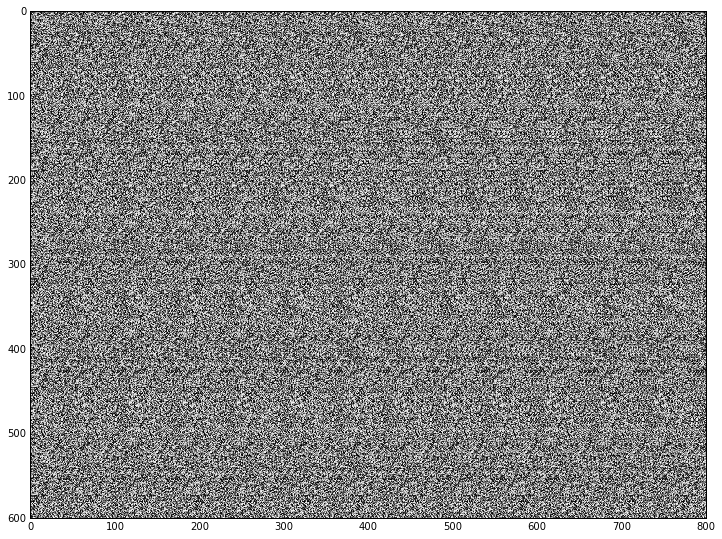

In [29]:
display(autostereogram)

# Conclusions 

In this blog post, I have demonstrated how to create your own autostereograms. Even though the result is not perfect, it is nonetheless interesting to see that the illusion of depth is mainly created by a horizontal shifts of patterns. I plan to write a follow-up to this post to explore what makes an autostereogram great (pattern choice, depth factor, number of gray levels...) and demonstrate some of the more interesting applications of this technique. For instance: maps, data, mathematical functions... 
Another interesting topic, [which has already been explored on other blogs](http://www.kscottz.com/solving-autostereograms-aka-magic-eyes/), involves how to produce the inverse transform from autostereogram to depthmap. Let's keep that in mind for some other time!

This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20160803_Autostereograms.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20160803_Autostereograms.ipynb).